## Group Assignment
### Team Number: 13
### Team Member Names: Mustafa Mian, Kabir Jain, Tra Luu
### Team Strategy Chosen: Market Beat

Disclose any use of AI for this assignment below (detail where and how you used it).  Please see the course outline for acceptable uses of AI.
- We used chatGPT to help debug our generate_numbers() function. Our version (that we needed to debug) was not always producing numbers above the min weight bound.

In [1]:
import subprocess
import pkg_resources
def check_and_update_yfinance():
    try:
        # Check the installed version of yfinance
        installed_version = pkg_resources.get_distribution("yfinance").version
        print(f"Currently installed yfinance version: {installed_version}")
    except pkg_resources.DistributionNotFound:
        print("yfinance is not installed.")
        installed_version = None
    # Update or install the latest version
    print("Checking for the latest version of yfinance...")
    try:
        subprocess.check_call(["pip", "install", "--upgrade", "yfinance"])
        print("yfinance has been updated to the latest version.")
    except subprocess.CalledProcessError as e:
        print("An error occurred while updating yfinance:", e)
if __name__ == "__main__":
    check_and_update_yfinance()

/var/folders/7x/z5l3v4x13gv5wlh0qdjwgllh0000gn/T/ipykernel_78151/1473345619.py:2: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import pkg_resources


Currently installed yfinance version: 0.2.54
Checking for the latest version of yfinance...
  Using cached yfinance-0.2.57-py2.py3-none-any.whl.metadata (5.8 kB)
Using cached yfinance-0.2.57-py2.py3-none-any.whl (113 kB)
  Attempting uninstall: yfinance
    Found existing installation: yfinance 0.2.54
    Uninstalling yfinance-0.2.54:
      Successfully uninstalled yfinance-0.2.54
yfinance has been updated to the latest version.


The above block of code is used to make sure that we have the latest yfinance version so that there are no errors.

In [6]:
from IPython.display import display, Math, Latex

import pandas as pd
import numpy as np
import numpy_financial as npf
import yfinance as yf
import matplotlib.pyplot as plt
import random
from datetime import datetime
import itertools # Library for creating and using "Iterators" on multiple python types.


These variables are defined for the calculations and to create our portfolio. We use flat fee and fee per share because the assignment states to use the lower price for the flat fee or fee per share. Investment size will be manipulated as we move through the ticker list to reflect purchases. We also read in the Ticker file.

In [7]:
investment_size = 1000000
min_stocks = 12
max_stocks = 24
flat_fee = 3.95
fee_per_share = 0.001
ticker_file = pd.read_csv('Tickers.csv', header=None)
ticker_file.rename(columns={0: 'name'}, inplace=True)

## The Risk Free Rate:

Here, we define the risk free rate. This will be an important value later on, when we evaluate portfolios using the sharpe ratio. We use the ticker "^IRX", which represents the yield of 3-month US govenrment debt. We use this ticker because government debt (especially for countries like the US) is very secure and is an almost risk-free investment since it is very unlikely the US will default. Therefore, this security represents how much risk free profit you can earn.

In [8]:
# Defining the ticker for 3-month US government debt
debt_ticker = '^IRX'
start_date = '2024-11-22'
end_date = '2024-11-23'

# Fetch historical data
us_debt = yf.Ticker(debt_ticker)

# Print the most recent closing value
risk_free_rate = us_debt.fast_info.last_price
risk_free_rate /= 100

## Clean Data: `clean_data()`
- First, our code will filter stocks that trade in USD or CAD.
- Next, we ensure that monthly trading data contains at least 18 trading days (indicating sufficient trading activity).
- We then check if the average monthly trading volume is at least 100,000 shares.
- Then we return the filtered list (`ticker_file`) of tickers meeting these criteria.

In [9]:
def clean_data(tickers):
    # NEW CODE
    tickers.drop_duplicates(inplace=True)
    
    # NEW CODE
    tickers['base_name'] = tickers['name'].str.replace(r'\.TO$', '', regex=True)
    tickers = tickers.drop_duplicates(subset='base_name')
    tickers = tickers.drop(columns=['base_name'])

    filtered_stocks = pd.DataFrame()
    start_date = "2023-10-01"
    end_date = "2024-09-30"
    for ticker in tickers['name']:
        try:
            stock = yf.Ticker(ticker)
            info = stock.fast_info
            if info['currency'] not in ["USD", "CAD"]: # Enusring stock is listed, traded in CAD or USD
                continue
    
            hist = stock.history(start=start_date, end=end_date, interval="1d")
            hist['Month'] = hist.index.to_period('M')
            monthly_data = hist.groupby('Month').filter(lambda x: len(x) >= 18)

            avg_monthly_volume = monthly_data.groupby('Month')['Volume'].mean().mean()
            if avg_monthly_volume >= 100000:
                filtered_stocks = pd.concat([filtered_stocks, pd.DataFrame({"Ticker": [ticker]})])
                
        except Exception as e:
            continue
    
    return filtered_stocks.reset_index(drop=True)

<span style="color:red">Our clean_data() function originally did not account for certain tickers in the ticker file. Firstly, we forgot to remove duplicates, meaning that a stock that was repeated twice in the portfolio would potentially get considered/bought twice, which we have now accounted for by removing duplicates. This is accomplished by using the Pandas drop_duplicate function.</span>

<span style="color:red">Another, similar problem we did not account for was having the same company listed on multiple exchanges. For example, when our code was run with the real ticker file we accidentally bought Shopify twice, once under the "SHOP" ticker andd once under the "SHOP.TO" ticker. This is incorrect as it makes the stock potentially violate the weight restrictions, as we get more exposure to a given company. This is accomplished by first removing the suffix ".TO" from all tickers (if needed) and placing these names in a new dataframe column, "base_name". We then use the Pandas drop_duplicate function to get rid of any duplicated names in the "base_name" column. The "base_name" column is then removed. This results a Dataframe with only the non TSX listed versions of all stocks that were duplicated.</span>

In [10]:
ticker_file = clean_data(ticker_file)

$ASDFAASDF.TO: possibly delisted; no price data found  (period=5d) (Yahoo error = "No data found, symbol may be delisted")
/var/folders/7x/z5l3v4x13gv5wlh0qdjwgllh0000gn/T/ipykernel_80050/2742471732.py:21: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  hist['Month'] = hist.index.to_period('M')
/var/folders/7x/z5l3v4x13gv5wlh0qdjwgllh0000gn/T/ipykernel_80050/2742471732.py:21: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  hist['Month'] = hist.index.to_period('M')
/var/folders/7x/z5l3v4x13gv5wlh0qdjwgllh0000gn/T/ipykernel_80050/2742471732.py:21: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  hist['Month'] = hist.index.to_period('M')
/var/folders/7x/z5l3v4x13gv5wlh0qdjwgllh0000gn/T/ipykernel_80050/2742471732.py:21: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  hist['Month'] = hist.index.to_period('M')
/

## Indices
`SP_index_hist` This ensures that the performance of the S&P 500 is converted to the same currency as the TSX Index, enabling direct comparison and combination.
Because the S&P 500 index is denominated in USD while the TSX index is in CAD, Directly comparing or combining these indices would be misleading without adjusting for the currency difference.

`benchmark` A benchmark index is created by averaging the adjusted S&P 500 Index (in CAD terms) and the TSX Index:
* This benchmark reflects a composite measure of market performance across both Canadian and US markets, adjusted for exchange rate differences.
* It provides a fair comparison for evaluating the performance of individual stocks.

Our goal is to beat the returns of this benchmark.

In [11]:
TSX_index = yf.Ticker('XIU.TO')
SP_index = yf.Ticker('^GSPC')
cadusd = yf.Ticker('CADUSD=x')

# Will edit these later
start_date = '2023-11-14'
end_date = '2024-11-23'

TSX_index_hist = TSX_index.history(start=start_date, end=end_date)['Close']
TSX_index_hist.index = TSX_index_hist.index.strftime('%Y-%m-%d')
SP_index_hist = SP_index.history(start=start_date, end=end_date)['Close']
SP_index_hist.index = SP_index_hist.index.strftime('%Y-%m-%d')
cadusd_history = cadusd.history(start=start_date, end=end_date)['Close']
cadusd_history.index = cadusd_history.index.strftime('%Y-%m-%d')

SP_index_hist = SP_index_hist / cadusd_history

benchmark = (TSX_index_hist + SP_index_hist) / 2

This portion of the code calculates the **beta** of a stock (its sensitivity to market movements) relative to the S&P 500 index and retrieves its current price. It uses historical price data to compute daily returns for both the stock and the index, determines the stock's variance relative to the index, and calculates beta. If the stock's currency is in USD, it converts the price to CAD using the latest exchange rate. The function ultimately returns the beta value and the adjusted stock price, providing insights into the stock's volatility and current valuation.

SP_ticker: Represents the ticker for the S&P 500 index (^GSPC).
cur_stock: Fetches stock data for the given ticker symbol using the yfinance library.
SP_index: Fetches stock data for the S&P 500 index.

Using these variables, we retrieve histroical data about the given stock and the historical data from the S&P 500.

We then create dataframe display the closing prices of both and calculate the daily returns.
Using this data we are able to calculate the beta value which is covariance of the stock's returns with the S&P 500 index, divided by the S&P 500 variance. 

Beta is useful for portfolio creation because:
1.  Beta indicates how a stock's price reacts to market movements:
Beta > 1: The stock is more volatile than the market. If the market moves 1%, the stock might move more than 1% in the same direction.
Beta < 1: The stock is less volatile than the market, moving less dramatically than the market.
Beta = 1: The stock moves in sync with the market.
Beta < 0: The stock moves inversely to the market.

2. Beta captures systematic risk, which is the risk inherent to the entire market. Unlike unsystematic risk (company-specific), systematic risk cannot be eliminated through diversification.



In [12]:
def getBeta(cur_ticker):
    cur_stock = yf.Ticker(cur_ticker)

    # Will edit these later
    start_date = '2023-11-14'
    end_date = '2024-11-23'

    cur_stock_hist = cur_stock.history(start=start_date, end=end_date)
    cur_stock_hist.index = cur_stock_hist.index.strftime('%Y-%m-%d')

    prices = pd.DataFrame()
    prices[cur_ticker] = pd.DataFrame(cur_stock_hist['Close'])
    prices['Average Index'] = benchmark

    daily_returns = prices.pct_change(fill_method=None).dropna()
    daily_returns.drop(index=daily_returns.index[0], inplace=True)

    SP_var = daily_returns['Average Index'].var()
    SP_beta = daily_returns.cov() / SP_var
    currency = cur_stock.fast_info.currency
    todays_price = prices[cur_ticker].iloc[-1]

    if currency == 'USD':
        exchange = cadusd.fast_info.last_price
        todays_price = todays_price / exchange
    
    return SP_beta.iat[0,1], todays_price

## Growth Function: `getGrowth()`
The function `getGrowth` calculates and returns the average daily growth rate (in percentage terms) of each stocks over given period. 

* The idea is that we extract the closing prices of stocks and use `pct_change()` to calculates the percentage change between consecutive days (daily returns)

* Note that: We use `dropna()` to remove the first row, which will be NAN since there's no previous price for the first day

* Formula for daily return of stocks:

 $$
Daily\ Return = \frac{Current\ Day's\ Price - Previous\ Day's\ Price}{Previous\ Day's\ Price}
$$


In [13]:
# Gets average of daily growth
def getGrowth(cur_ticker):
    # Fetch data for current stock
    cur_stock = yf.Ticker(cur_ticker)
    start_date = '2023-11-14'
    end_date = '2024-11-23'
    cur_stock_hist = cur_stock.history(start=start_date, end=end_date)

    prices = pd.DataFrame()
    prices[cur_ticker] = cur_stock_hist['Close']
    
    daily_returns = prices.pct_change(fill_method=None).dropna()
    SP_growth = daily_returns.mean()
    
    return SP_growth[cur_ticker] * 100

The getVolatility function calculates the volatility of a stock over a specified time period. Volatility measures the degree of variation in the stock's daily returns and is often used as an indicator of risk.

The function will retrieve the percentage change everyday and calculate the volatility through the standard deviation function.
Volatility is a critical metric in stock analysis and portfolio management because it reflects the degree of risk and uncertainty associated with a stock's price movements. Including volatility in stock-related functions is beneficial for several reasons:

1. Volatility represents the fluctuations in a stock's price over a given period. A highly volatile stock experiences larger price swings, indicating higher risk.
Low volatility suggests stable price movements, which might be attractive to risk-averse investors.

2. While beta measures a stock's volatility relative to the market, volatility measures absolute risk, irrespective of market movements.
Combining volatility with other metrics like beta and expected return provides a more comprehensive view of a stock’s risk-reward profile.

3. Investors can adjust their portfolio composition based on the volatility of individual stocks:
High-volatility stocks are suitable for aggressive investors seeking higher potential returns but willing to tolerate risk.
Low-volatility stocks appeal to conservative investors prioritizing stability. In this case we are on the higher risk tolarance side. In order to beat the market we understand we have to toake on a reasonable amount of risk (but not excessive)

In [14]:
def getVolatility(cur_ticker):
    start_date = '2023-11-14'
    end_date = '2024-11-23'
    stock_data = yf.Ticker(cur_ticker).history(start=start_date, end=end_date)
    stock_data['Daily Return'] = stock_data['Close'].pct_change(fill_method=None).dropna()
    
    volatility = stock_data['Daily Return'].std()
    return volatility

## **Stock Analysis and Ranking Process**

Now, we will explain the logic and steps followed to analyze and rank a list of stocks based on their Beta, Growth, and Volatility, combining these factors into a weighted scoring system

1. Stock Data Retrieval:
* We use the `yfinance` library to fetch historical stock price data for * each ticker symbol from ticker_file.
* Date range: 2023-11-14 to 2024-11-21.

2. Statistic Computation:
- Beta `getBeta()`: Measures a stock's volatility relative to the market.
- Growth `getGrowth()`: Average daily growth rate of the stock.
- Volatility `getVolatility()`: Measures the stock's price fluctuations 

3. Ranking Criteria:
Three separate sorted lists (Descending order) are created:
- `beta_data`: Higher Beta stocks are ranked higher.
- `growth_data`: Stocks with higher growth potential are ranked higher.
- `volatility_data`: Stocks with higher volatility are ranked higher

4. Weighted Index Calculation:
   
- **Weights:**
    - Beta: 40%
    - Growth: 30%
    - Volatility: 30%

    *The weights for each criterion are chosen to reflect the strategic importance of different factors in our portfolio.*


    * Beta (40%)   
    We assign a 40% weight to Beta to emphasize stocks that are highly sensitive to market movements. High-Beta stocks tend to amplify market trends, outperforming during conditions where the market is trending upward. Since our portfolio is significantly reliant on market momentum, we consider Beta to be the most critical factor.

    * Growth (30%)    
    Growth represents a stock’s potential to increase in value based on revenue, earnings, or other key financial metrics. By allocating a 30% weight to Growth, we will ensure the inclusion of fundamentally strong stocks, creating a balance that mitigates some of the risks associated with high Beta and Volatility.

    * Volatility (30%)  
    Volatility measures the degree of price fluctuations over time. Volatile stocks offer opportunities for rapid gains through frequent and significant price movements. A 30% weight on Volatility ensures that our portfolio includes dynamic stocks with short-term trading potential while maintaining a balanced risk profile. We understand that risk is necessary, but we don't want to ignore it entirely, considering this portfolio is meant to be a long term investment.


- **Process:**
    * For each stock, its rank in the Beta, Growth, and Volatility lists is multiplied by the respective weight.
    * The weighted indices are summed up to calculate a total weighted index for each stock.


- **Normalization:**

    * Stocks are assigned a weighted index position, combining their rankings across all three criteria. 


5. Sorting the Final Results:
- The stocks are sorted in ascending order of their weighted index:

- Stocks with a lower weighted index (better average rank across criteria) are ranked higher. Then, we will store them in `result`
The final list `result` highlights the top-performing stocks according to the combined metrics. 

**Why this method?**

We believe that this method allows us to rank the stocks relative to each other, rather than some arbitrary conditions/cutoffs we decide beforehand. We do not know the stocks we are recieving, so we can't make judgement on what qualifies as a "good" stock in advance.

In [15]:

# Initialize the lists
stock_data = []
beta_data = []
volatility_data = []
growth_data = []

# Iterate through the tickers and gather data
for i in range(len(ticker_file)):
    cur_ticker = ticker_file['Ticker'].iloc[i]
    cur_stock = yf.Ticker(cur_ticker)
    start_date = '2023-11-14'
    end_date = '2024-11-23'
    cur_stock_hist = cur_stock.history(start=start_date, end=end_date)['Close']

    # Getting important statistics per stock
    beta, price = getBeta(cur_ticker)
    beta_data.append({"name": cur_ticker, "beta": beta})
    growth = getGrowth(cur_ticker)
    growth_data.append({"name": cur_ticker, "growth": growth})
    volatility = getVolatility(cur_ticker)
    volatility_data.append({"name": cur_ticker, "volatility": volatility})

    # Store combined stock details
    stock_details = {
        "name": cur_ticker,
        "beta": beta,
        "growth": growth,
        "volatility": volatility,
        "price": price,
        "price_history": cur_stock_hist
    }
    stock_data.append(stock_details)

# Sort the data by each criterion
sorted_betas = sorted(beta_data, key=lambda d: d['beta'], reverse=True)
sorted_growth = sorted(growth_data, key=lambda d: d['growth'], reverse=True)
sorted_volatility = sorted(volatility_data, key=lambda d: d['volatility'], reverse=True)

# Combine the lists into one iterable
lists = [sorted_betas, sorted_growth, sorted_volatility]
weights = [0.4, 0.3, 0.3]  # Corresponding weights for beta, growth, and volatility

# Step 1: Calculate weighted average index position for each stock
index_map = {}
for weight, lst in zip(weights, lists):
    for index, stock in enumerate(lst):
        name = stock["name"]
        if name not in index_map:
            index_map[name] = 0
        # Add the weighted index to the total
        index_map[name] += index * weight

# Step 2: Convert index_map to a list of dictionaries for sorting
weighted_positions = [
    {"name": name, "weighted_index": total_index}
    for name, total_index in index_map.items()
]

# Step 3: Sort stocks by their weighted index
sorted_by_weighted = sorted(weighted_positions, key=lambda x: x["weighted_index"])

# Final result: A list of stocks sorted by the weighted average of their index positions
result = [{"name": stock["name"], "weighted_index": stock["weighted_index"]} for stock in sorted_by_weighted]


In [16]:
best_stocks = []
for i in range(24):
    best_stocks += [result[i]["name"]]

Here we print our best 24 stocks:

In [17]:
filtered_stocks = []
for stock in best_stocks:
    for stock_stats in stock_data:
        if (stock == stock_stats["name"]):
            filtered_stocks += [stock_stats]

filtered_stocks

[{'name': 'HOOD',
  'beta': 2.2571418581136524,
  'growth': 0.63834769509191,
  'volatility': 0.03777487619111049,
  'price': 52.350495162292624,
  'price_history': Date
  2023-11-14 00:00:00-05:00     8.500000
  2023-11-15 00:00:00-05:00     8.330000
  2023-11-16 00:00:00-05:00     7.940000
  2023-11-17 00:00:00-05:00     8.100000
  2023-11-20 00:00:00-05:00     8.130000
                                 ...    
  2024-11-18 00:00:00-05:00    35.000000
  2024-11-19 00:00:00-05:00    35.240002
  2024-11-20 00:00:00-05:00    36.080002
  2024-11-21 00:00:00-05:00    35.090000
  2024-11-22 00:00:00-05:00    36.650002
  Name: Close, Length: 259, dtype: float64},
 {'name': 'SQ',
  'beta': 1.672627084118312,
  'growth': 0.24249145584613152,
  'volatility': 0.029391265981265007,
  'price': 131.78326314926437,
  'price_history': Date
  2023-11-14 00:00:00-05:00    55.099998
  2023-11-15 00:00:00-05:00    56.299999
  2023-11-16 00:00:00-05:00    56.279999
  2023-11-17 00:00:00-05:00    58.189999

---
## **Portfolio Simulation**
- What is our simulation strategy?

We will use a computational technique used to estimate outcomes of complex systems or processes by:

1. Generating random inputs.

2. Repeatedly running simulations with randomized inputs.

3. Aggregating results to analyze probabilities, trends, or expectations.

This method allows us to obtain a distribution of results for any statistical problem with numerous inputs sampled over and over again.

According to our research, this method is commonly used in finance. Now, we will use this method for portfolio optimization. Instead of relying on a static model that assumes weight allocations or number of stocks, this allows us to test portfolio weights under varying conditions to understand how they perform across a range of outcomes.

The model is run many times, with each set of random values producing a different outcome. By running the simulation multiple times and looking at the distribution of outcomes, we can get a sense of which outcomes are most likely. We use this method to simulates thousands of portfolios to determine the optimal weights of stocks that maximizes returns. 

Hence, by this method, we can pick random weights, and next quantify the portfolios from 12 stocks to 24 stocks. Then, we can rank and pick the best portfolio. 

- In this context, we will use `generate_numbers()`:
  - We want to generate random weight for each stock
  - Produces randomized input data for each iteration of the simulation.
  - Ensures the inputs adhere to constraints: Values within `[min_value, max_value]`, the sum of the values equals `total_sum`.

  The `random.random()` component introduces variability for sampling.

  By adjusting the weights and scaling the sum to match `total_sum`, the function ensures all samples meet required conditions.

  A `scaling_factor` ensures the sum of the adjusted weights matches `remaining_sum`




In [18]:
def generate_numbers(n, min_value, max_value, total_sum):
    total_lower = n * min_value
    total_upper = n * max_value
    if total_sum < total_lower or total_sum > total_upper:
        raise ValueError("Cannot generate numbers with the given constraints.")

    # Calculate the adjusted sum we need to distribute
    remaining_sum = total_sum - total_lower
    adjusted_upper_bounds = [max_value - min_value] * n

    # Generate initial random values
    u = [random.random() for _ in range(n)]
    adjusted_weights = [u_i * adjusted_upper_bounds[i] for i, u_i in enumerate(u)]
    adjusted_weights_sum = np.sum(adjusted_weights)

    # Scale the weights to match the remaining sum
    scaling_factor = remaining_sum / adjusted_weights_sum
    adjusted_weights = [w_i * scaling_factor for w_i in adjusted_weights]

    # Compute the final values
    x = [min_value + w_i for w_i in adjusted_weights]

    return x

In [19]:
for stock in filtered_stocks:
    stock["price_history"].index = stock["price_history"].index.strftime('%Y-%m-%d')

---
## **Portfolio Optimization**
**Overall:**

The `make_portfolios` function generates and evaluates stock portfolios to identify the strongest ones based on metrics such as portfolio return, Sharpe ratio, and beta. It creates random portfolios with 12 to 24 stocks by assigning weights within specified limits and allocating a given budget accordingly. For each portfolio, the function calculates transaction fees, daily values, cumulative returns, and risk-adjusted metrics while benchmarking performance against the average of the TSX and S&P 500 indices. The best-performing portfolio for each stock count is selected based on an investment coefficient that balances return, risk, and market sensitivity. Finally, the function plots portfolio performance against the benchmark and returns the strongest portfolios for further analysis.

**Process**

1. Simulate Portfolio:

   For each portfolio size n (ranging from 12 to 24 stocks):

   1. Random Weight Generation
    Stocks are assigned random weights within:

    * Minimum weight: $\frac{100}{2n}$ %
    
    * Maximum weight: 15%.

    *Note: Transaction fees are deducted before calculating the number of shares purchased.*


   2. Calculate Portfolio Metrics:
   
    * **Portfolio Return (50%)**: Measures the portfolio's total percentage gain/loss over the period.
    
    $$
    Portfolio\ Return = \frac{Final\ Portfolio\ Value - Initial\ Portfolio\ Value}{Initial\ Portfolio\ Value}
    $$

    * **Sharpe Ratio (20%)**: Risk-adjusted return calculated using daily portfolio returns.
    
    $$
    Sharpe\ Ratio = \frac{Average\ Daily\ Return - Risk\ Free\ Rate}{Standard\ Deviation\ of\ Daily\ Return}
    $$
    
    * **Portfolio Beta (30%)**: The portfolio’s overall market sensitivity, based on weighted beta values of the stocks.

    $$ Portfolio\ Beta = Σ (Stock\ Beta_i × \frac{Stock\ Weight_i}{100}) $$


    **The reasons why our group use this weighted formula to combine these three metrics is that:**
        
    * We want to prioritize Return (50%) to ensure the portfolio grows effectively
    * Beta (30%) maintains sensitivity to market trends and aligns the portfolio with market movements. We want to take risk, so we will put more weight on beta, especially growth
    * Sharpe Ratio (20%) We want to ensure efficient risk management to prevent extreme volatility
 
 
   3. Compute Investment Coefficient:
    * We then combines the metrics into a single score using
  
         $$Investment\ Coefficient= 0.3 × Portfolio\ Beta+ 0.5 × Portfolio\ Return + 0.2 × Sharpe\ Ratio $$

    The reason why we use Investment Coefficient is that this result allows us to balance the allocation of resources across various assets. This is a number we made up to reflect our portfolio score.


   4. Select the Best Portfolio:
    - Among 1000 randomly simulated portfolios, the one with the highest investment coefficient is chosen as the strongest portfolio for that size


2. Store results:
   
    For each portfolio size n: 
    - The best portfolio (as a DataFrame) are stored in `strongest_portfolios`
    - Its daily back-testing performance (value over time) are stored in `back_testing_portfolios`

3. Visualization:
 
     We then generates a plot comparing:
    - Benchmark Performance: Average cumulative returns of TSX and S&P indices.
    - Strongest Portfolios: Cumulative returns of the best portfolios for each size 
    n
    n.

**Conclusion:**

Generating multiple portfolios is valuable because it allows investors to explore a wide range of potential combinations, ensuring the identification of the most optimal one based on key metrics like return, risk, and Sharpe ratio. By simulating diverse allocation strategies, it provides a more robust understanding of how different portfolios perform under varying market conditions, similar to the Monte Carlo method. This approach also helps mitigate risk through diversification and ensures alignment with budget, stock weight constraints, and investment goals. Ultimately, it improves decision-making by enabling a data-driven evaluation of the best-performing portfolios.

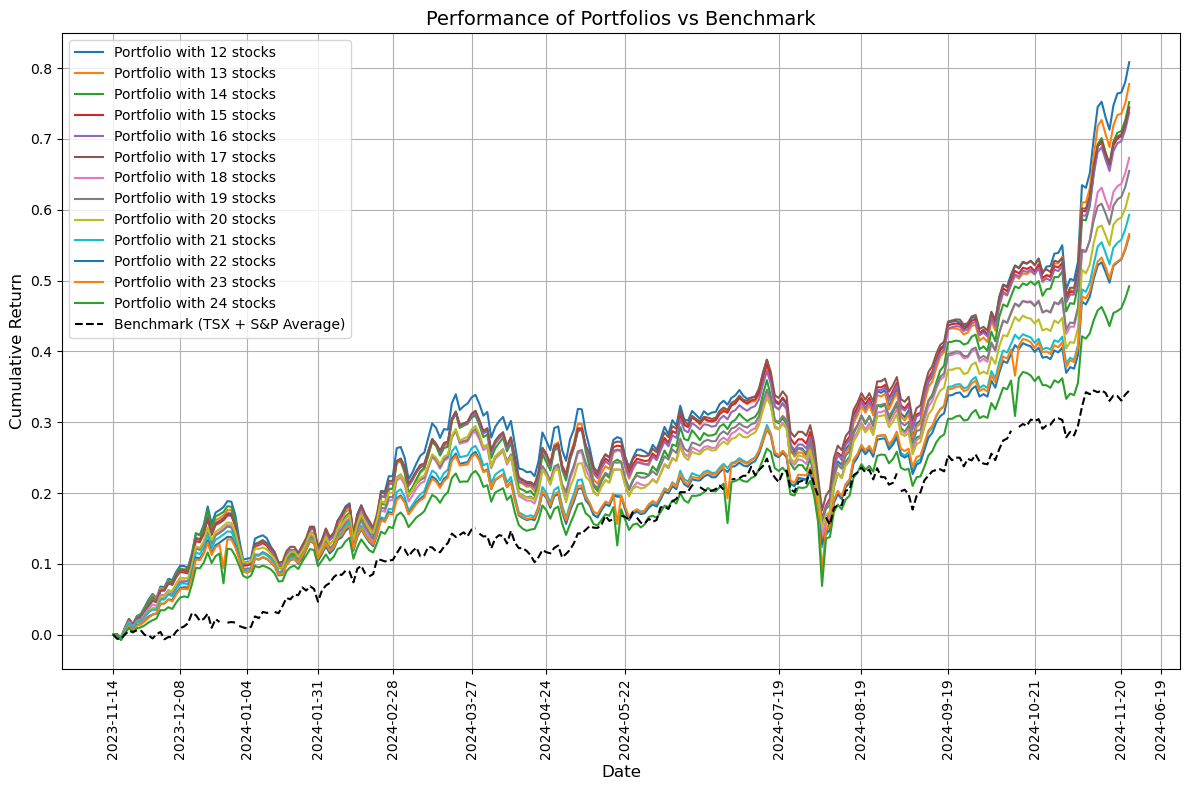

In [20]:
def make_portfolios(stock_details, budget):
    # Dictionary of best portfolio with 12, 13, ... n stocks
    strongest_portfolios = {}

    # Dictionary containing the daily value of the strongest_portfolios, backtested on a year's worth of data.
    back_testing_portfolios = {}

    for n in range(12, 25):  # Loop through the number of stocks in the portfolio
        best_portfolio = None # DataFrame of best portfolio n stocks
        best_portfolio_backtesting = None
        best_invest_coeff = float('-inf') # Setting this value to an infinitely small number to begin

        for j in range(1000):  # Create 1000 portfolios with different weights for the current number of stocks
            stocks = stock_details[:n]
            max_weight = 15
            min_weight = 100 / (2 * n)
            generate = True
            
            # Generate valid weights for the portfolio
            while generate:
                weights = generate_numbers(n, min_weight, max_weight, 100)
                if all(min_weight <= weight <= max_weight for weight in weights):
                    generate = False
            
            weights.sort(reverse=True)

            current_portfolio = pd.DataFrame()
            fees_spent = 0
            total_spent = 0

            # Create a dataframe for daily portfolio value calculation
            portfolio_values = pd.DataFrame()
            
            for i in range(len(stocks)):
                stock_weight = weights[i]
                money_allocated = budget * (stock_weight / 100)  # Allocate money based on weight
                
                # Deduct the flat fee initially to estimate spendable money
                flat_fee = 3.95
                money_for_stock = money_allocated - flat_fee
                
                if money_for_stock < 0:
                    shares = 0
                    transaction_fees = 0
                else:
                    shares = money_for_stock / stocks[i]["price"]  # Calculate shares
                    variable_fee = shares * 0.001
                    transaction_fees = min(flat_fee, variable_fee)  # Use the smaller fee
                    
                    # Adjust the number of shares based on fees
                    money_for_shares = money_allocated - transaction_fees
                    shares = money_for_shares / stocks[i]["price"]
                    actual_spent = shares * stocks[i]["price"] + transaction_fees
                    
                    # Update total spent and fees
                    total_spent += actual_spent
                    fees_spent += transaction_fees
                
                # Append stock details to the current portfolio
                new_row = {
                    'Name': stocks[i]["name"],
                    'weight': weights[i],
                    'shares': shares,
                    'price': stocks[i]["price"],
                    'transaction fees': transaction_fees,
                    'spent': actual_spent,
                    'weighted beta': stocks[i]['beta'] * (weights[i] / 100)
                }
                current_portfolio = pd.concat([current_portfolio, pd.DataFrame(new_row, index=[0])], ignore_index=True)
                
                # Add stock's daily value (shares * daily price) to the portfolio_values dataframe
                stock_values = stocks[i]["price_history"] * shares
                portfolio_values[stocks[i]["name"]] = stock_values
            
            # Compute portfolio total value
            portfolio_values['Portfolio'] = portfolio_values.sum(axis=1)
            
            # Calculate portfolio return from first day to final day when backtested on about a years worth of data
            portfolio_return = (
                portfolio_values['Portfolio'].iloc[-1] - portfolio_values['Portfolio'].iloc[0]
            ) / portfolio_values['Portfolio'].iloc[0]
            
            # Calculate portfolio daily returns and Sharpe ratio
            daily_returns = portfolio_values['Portfolio'].pct_change().dropna()
            avg_daily_return = daily_returns.mean()
            std_daily_return = daily_returns.std()
            sharpe_ratio = (avg_daily_return - risk_free_rate) / std_daily_return if std_daily_return > 0 else 0
            
            # Calculate portfolio beta
            portfolio_beta = current_portfolio['weighted beta'].sum()
            
            # Compute investment coefficient
            investment_coefficient = (20 * portfolio_beta) + (60 * portfolio_return) + (20 * sharpe_ratio)
            
            # Check if this portfolio is the best for this number of stocks
            if investment_coefficient > best_invest_coeff:
                best_invest_coeff = investment_coefficient
                best_portfolio = current_portfolio.copy()
                best_portfolio_backtesting = portfolio_values.copy()
                best_portfolio["Portfolio Return"] = portfolio_return
                best_portfolio["Sharpe Ratio"] = sharpe_ratio
                best_portfolio["Investment Coefficient"] = investment_coefficient

        # Store the best portfolio for this number of stocks
        strongest_portfolios[n] = best_portfolio
        back_testing_portfolios[n] = best_portfolio_backtesting
        
        # Add a summary row to the best portfolio
        final_row = {
            'Name': 'Total',
            'weight': best_portfolio['weight'].sum(),
            'shares': best_portfolio['shares'].sum(),
            'price': best_portfolio['price'].sum(),
            'transaction fees': best_portfolio['transaction fees'].sum(),
            'spent': best_portfolio['spent'].sum(),
            'weighted beta': portfolio_beta,
            'Portfolio Return': best_portfolio["Portfolio Return"].iloc[0],
            'Sharpe Ratio': best_portfolio["Sharpe Ratio"].iloc[0],
            'Investment Coefficient': best_invest_coeff
        }
        strongest_portfolios[n] = pd.concat([best_portfolio, pd.DataFrame(final_row, index=[0])], ignore_index=True)

    # Graphing the performance of the strongest portfolios and the benchmark
    plt.figure(figsize=(12, 8))

    # Plot the strongest portfolios
    for n, portfolio_values in back_testing_portfolios.items():
        portfolio_cum_return = (portfolio_values['Portfolio'] / portfolio_values['Portfolio'].iloc[0]) - 1
        plt.plot(portfolio_cum_return.index, portfolio_cum_return, label=f"Portfolio with {n} stocks")

    # Plot benchmark performance
    benchmark_cum_return = (benchmark / benchmark.iloc[0]) - 1
    plt.plot(benchmark.index, benchmark_cum_return, label="Benchmark (TSX + S&P Average)", color="black", linestyle="--")

    # Customize plot
    plt.title("Performance of Portfolios vs Benchmark", fontsize=14)
    plt.xlabel("Date", fontsize=12)
    plt.ylabel("Cumulative Return", fontsize=12)
    ticks = ['2023-11-14', '2023-12-08', '2024-01-04', '2024-01-31', '2024-02-28', '2024-03-27', '2024-04-24', '2024-05-22', '2024-06-19', '2024-07-19', '2024-08-19', '2024-09-19', '2024-10-21', '2024-11-20']
    plt.xticks(ticks, rotation=90)
    plt.legend(fontsize=10, loc="upper left")
    plt.grid(True)
    plt.tight_layout()

    plt.show()
    
    return strongest_portfolios

best_portfolios = make_portfolios(filtered_stocks, investment_size)

Finally, the function plots portfolio performance against the benchmark and returns the strongest portfolios for further analysis. This graph represents our best portfolios when backtested on a year's worth of data.

We can see that many of these portfolios outperform the benchmark in returns. Since we rank our portfolio's based on Investment Coefficient, and 60% of this coefficient is based on returns, it is highly likely that the portfolio chosen will be one of the highest performing lines in the above graph. Of course, we do not know the stocks we are given (and so results may vary), but we expect to see this general trend.

We pick the portfolio with the highest investment coefficient and select it as our best portfolio.

In [21]:
best_port = pd.DataFrame()
best_investment_coeff = 0
for i in range(12, 25):
    cur_portfolio = best_portfolios[i]
    cur_investment_coeff = cur_portfolio['Investment Coefficient'].iloc[0]

    if cur_investment_coeff > best_investment_coeff:
        best_investment_coeff = cur_investment_coeff
        best_port = cur_portfolio

display(best_port)

,Name,weight,shares,price,transaction fees,spent,weighted beta,Portfolio Return,Sharpe Ratio,Investment Coefficient
0,HOOD,14.928567,2851.602849,52.350495,2.851582,1.492857e+05,0.336959,0.808273,-2.626282,24.05278
1,SQ,14.280299,1083.611891,131.783263,1.083590,1.428030e+05,0.238856,0.808273,-2.626282,24.05278
2,DUOL,12.538551,249.398615,502.750425,0.249391,1.253855e+05,0.207686,0.808273,-2.626282,24.05278
3,SHOP,10.795479,706.595504,152.780592,0.706574,1.079548e+05,0.176940,0.808273,-2.626282,24.05278
4,ORCL,8.963507,327.144080,273.991642,0.327131,8.963507e+04,0.105989,0.808273,-2.626282,24.05278
5,GM,6.841573,822.258185,83.203684,0.822221,6.841573e+04,0.053472,0.808273,-2.626282,24.05278
6,AXP,6.772541,157.733731,429.364405,0.157725,6.772541e+04,0.055337,0.808273,-2.626282,24.05278
7,AMZN,5.951011,211.354609,281.564227,0.211341,5.951011e+04,0.081438,0.808273,-2.626282,24.05278
8,GOOG,5.248390,221.089198,237.386881,0.221073,5.248390e+04,0.053223,0.808273,-2.626282,24.05278
9,BAC,4.734481,713.612409,66.344270,0.713564,4.734481e+04,0.032949,0.808273,-2.626282,24.05278


Above we can see the final portfolio that has been selected by the code (**NOTE: This is NOT the final output, that will be displayed below**).

We can see the selected portfolio's return, sharpe ratio, and beta. The portfolio is selected based on its high Investment coefficent (Recall, this is the weighted sum of the return, S-ratio, and beta). The portfolio may include anywhere from 12 to 24 stocks, and is the best of thousands of simulated portfolios.

The "Total" row represents the final performance of the portfolilo, where we can see that our weights and spent amounts add up to 100% and $1000000, respectively.

In [22]:
Portfolio_Final = pd.DataFrame()
for i in range(len(best_port) - 1):
    new_row = {
        'Ticker': best_port["Name"].iloc[i],
        'Price': best_port["price"].iloc[i],
        'Currency': 'CAD',
        'Shares': best_port["shares"].iloc[i],
        'Value': best_port["spent"].iloc[i] - best_port["transaction fees"].iloc[i],
        'Weight': best_port["weight"].iloc[i],
    }
    Portfolio_Final = pd.concat([Portfolio_Final, pd.DataFrame(new_row, index=[0])], ignore_index=True)

Portfolio_Final.index = Portfolio_Final.index + 1
total_weight = Portfolio_Final["Weight"].sum()
total_spent_on_shares = Portfolio_Final["Value"].sum()
total_spent_with_fees = best_port["spent"].iloc[-1]
print("The total weight adds up to: ", total_weight, "%", sep='')
print("The total spent without fees adds up to: $", total_spent_on_shares, sep='')
print("The total spent with fees adds up to: $", total_spent_with_fees, sep='')
print()
print(Portfolio_Final)

# Create the "Stocks_Final" DataFrame
Stocks_Final = Portfolio_Final[['Ticker', 'Shares']]

# Save "Stocks_Final" to CSV
Stocks_Final.to_csv("Stocks_Group_13.csv")

The total weight adds up to: 100.00000000000004%
The total spent without fees adds up to: $999992.4916667637
The total spent with fees adds up to: $1000000.0000000002

   Ticker        Price Currency       Shares          Value     Weight
1    HOOD    52.350495      CAD  2851.602849  149282.821126  14.928567
2      SQ   131.783263      CAD  1083.611891  142801.911048  14.280299
3    DUOL   502.750425      CAD   249.398615  125385.259488  12.538551
4    SHOP   152.780592      CAD   706.595504  107954.079036  10.795479
5    ORCL   273.991642      CAD   327.144080   89634.743448   8.963507
6      GM    83.203684      CAD   822.258185   68414.910219   6.841573
7     AXP   429.364405      CAD   157.733731   67725.249488   6.772541
8    AMZN   281.564227      CAD   211.354609   59509.897178   5.951011
9    GOOG   237.386881      CAD   221.089198   52483.675274   5.248390
10    BAC    66.344270      CAD   713.612409   47344.094101   4.734481
11    JPM   353.202183      CAD   133.363867   4710

## Contribution Declaration

The following team members made a meaningful contribution to this assignment:

Insert Names Here.

Mustafa Mian

Tra Luu

Kabir Jain